In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
 !git clone https://github.com/tabayashi0117/Score-CAM.git

Cloning into 'Score-CAM'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 136 (delta 29), reused 11 (delta 11), pack-reused 97
Receiving objects: 100% (136/136), 60.27 MiB | 9.27 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [3]:
import tensorflow as tf
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
import numpy as np
#from gradcamutils import *

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import gc

tf.compat.v1.disable_eager_execution()

def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = tf.gradients(y_c, conv_output)[0]
    # grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  

    return cam

def GradCamPlusPlus(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = tf.gradients(y_c, conv_output)[0]
    # grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img_array])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)
    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))
    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)

    cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam) # scale 0 to 1.0  

    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsampled to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def superimpose(original_img_path, cam, emphasize=False):
    
    img_bgr = cv2.imread(original_img_path)

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, 0.5, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

import tensorflow.keras

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.applications.vgg16 import preprocess_input

def build_guided_model(build_model_function):
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model_function()
    return new_model

def GuidedBackPropagation(model, img_array, layer_name):
    model_input = model.input
    layer_output = model.get_layer(layer_name).output
    max_output = K.max(layer_output, axis=3)
    grads = tf.gradients(max_output, model_input)[0]
    get_output = K.function([model_input], [grads])
    saliency = get_output([img_array])
    saliency = np.clip(saliency[0][0], 0.0, 1.0)  # scale 0 to 1.0  
    return saliency

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def read_and_preprocess_img(path, size=(224,224)):
    img = load_img(path, target_size=size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

### test 1

Path /content/drive/MyDrive/Senior Project/Senior V 4 Grayscale/CLAHE/Output_InceptionResnetV2/output_clahe_inceptionresnet./Cemento_Gradcam/ does not exist. Creating.
Path /content/drive/MyDrive/Senior Project/Senior V 4 Grayscale/CLAHE/Output_InceptionResnetV2/output_clahe_inceptionresnet./Fibrous_Gradcam/ does not exist. Creating.
Path /content/drive/MyDrive/Senior Project/Senior V 4 Grayscale/CLAHE/Output_InceptionResnetV2/output_clahe_inceptionresnet./Ossifying_Gradcam/ does not exist. Creating.


Instructions for updating:
Colocations handled automatically by placer.
/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Now save Cemento_Gradcam no.0
Now save Cemento_Gradcam no.1
Now save Cemento_Gradcam no.2
Now save Cemento_Gradcam no.3
Now save Cemento_Gradcam no.4
Now save Cemento_Gradcam no.5
Now save Cemento_Gradcam no.6
Now save Cemento_Gradcam no.7
Now save Cemento_Gradcam no.8
Now save Cemento_Gradcam no.9
Now save Cemento_Gradcam no.10
Now save Cemento_Gradcam no.11
Now save Cemento_Gradcam no.12
Now save Cemento_Gradcam no.13
Now save Cemento_Gradcam no.14
Now save Cemento_Gradcam no.15
Now save Cemento_Gradcam no.16
Now save Cemento_Gradcam no.17
Now save Cemento_Gradcam no.18
Now save Cemento_Gradcam no.19
Now save Cemento_Gradcam no.20
Now save Cemento_Gradcam no.21
Now save Cemento_Gradcam no.22
Now save Cemento_Gradcam no.23
Now save Cemento_Gradcam no.24
Now save Cemento_Gradcam no.25
Now save Cemento_Gradcam no.26
Now save Cemento_Gradcam no.27
Now save Cemento_Gradcam no.28
Now save Cemento_Gradcam no.29
Now save Cemento_Gradcam no.30
Now save Cemento_Gradcam no.31
Now save Cemento_G

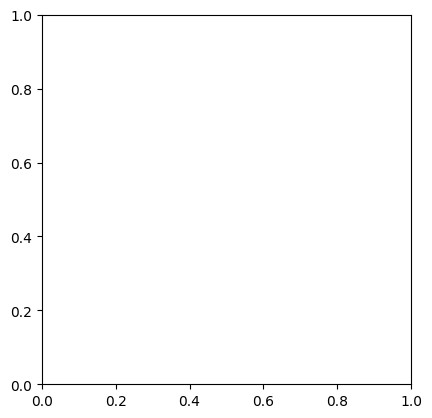

In [5]:
TYPE = "output_clahe_inceptionresnet"
PATH = os.path.join('/content/drive/MyDrive/Senior Project/Senior V 4 Grayscale/CLAHE')
# output_dir = './Output/split_'+TYPE
# test_dir = os.path.join(PATH, 'split_test')
output_dir = '/content/drive/MyDrive/Senior Project/Senior V 4 Grayscale/CLAHE/Output_InceptionResnetV2/'+TYPE
test_dir = os.path.join(PATH, 'split_test_cell/') #, 'test_cell'
test_cem_dir = os.path.join(test_dir, 'ce')
test_fib_dir = os.path.join(test_dir, 'fi')
test_oss_dir = os.path.join(test_dir, 'os')

BATCH_SIZE = 64
IMG_HEIGHT = 256
IMG_WIDTH = 256

output_cem = output_dir+"./Cemento_Gradcam/"
output_fib = output_dir+"./Fibrous_Gradcam/"
output_oss = output_dir+"./Ossifying_Gradcam/"

if not os.path.isdir(output_cem):
    print("Path {} does not exist. Creating.".format(output_cem))
    os.makedirs(output_cem)
else:
    print("Path {} exists. Remove and remake.".format(output_cem))
    shutil.rmtree(output_cem)
    os.makedirs(output_cem)

if not os.path.isdir(output_fib):
    print("Path {} does not exist. Creating.".format(output_fib))
    os.makedirs(output_fib)
else:
    print("Path {} exists. Remove and remake.".format(output_fib))
    shutil.rmtree(output_fib)
    os.makedirs(output_fib)

if not os.path.isdir(output_oss):
    print("Path {} does not exist. Creating.".format(output_oss))
    os.makedirs(output_oss)
else:
    print("Path {} exists. Remove and remake.".format(output_oss))
    shutil.rmtree(output_oss)
    os.makedirs(output_oss)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

model_clahe_inception = load_model('/content/drive/MyDrive/Senior Project/Senior V 4 Grayscale/CLAHE/Output_InceptionResNetV2/CLAHE_image_InceptionResNetV2/InceptionResNetV2_CLAHE_best.h5')
layer_name = model_clahe_inception.layers[-4].name

for i, name in enumerate(os.listdir(test_cem_dir)):
    img_path = test_cem_dir+"/"+name
    orig_img = np.array(load_img(img_path),dtype=np.uint8)
    img_array = np.array(load_img(img_path, target_size=(IMG_HEIGHT,IMG_WIDTH)))
    img_array = img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    faster_score_cam=ScoreCam(model_clahe_inception,img_array,layer_name, max_N=10)
    faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
    faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)
    plt.imshow(faster_score_cam_emphasized)
    # plt.show()
    plt.savefig(output_cem+name)
    plt.cla()
    print('Now save Cemento_Gradcam no.'+str(i))

for i, name in enumerate(os.listdir(test_fib_dir)):
    img_path = test_fib_dir+"/"+name
    orig_img = np.array(load_img(img_path),dtype=np.uint8)
    img_array = np.array(load_img(img_path, target_size=(IMG_HEIGHT,IMG_WIDTH)))
    img_array = img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    faster_score_cam=ScoreCam(model_clahe_inception,img_array,layer_name, max_N=10)
    faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
    faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)
    plt.imshow(faster_score_cam_emphasized)
    # plt.show()
    plt.savefig(output_fib+name)
    plt.cla()
    print('Now save Fibrous_Gradcam no.'+str(i))

for i, name in enumerate(os.listdir(test_oss_dir)):
    img_path = test_oss_dir+"/"+name
    orig_img = np.array(load_img(img_path),dtype=np.uint8)
    img_array = np.array(load_img(img_path, target_size=(IMG_HEIGHT,IMG_WIDTH)))
    img_array = img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    faster_score_cam=ScoreCam(model_clahe_inception,img_array,layer_name, max_N=10)
    faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
    faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)
    plt.imshow(faster_score_cam_emphasized)
    # plt.show()
    plt.savefig(output_oss+name)
    plt.cla()
    #print('Now save Ossifying_Gradcam no.'+str(i))